## Group Name : Inside Roll
## Group Members: 
#### 1. AIT2304037 Chin Jun Ming 
#### 2. AIT2304038 Chin Zheng Dong
#### 3. AIT2304041 Tan Wai Hong
#### 4. AIT2304043 Wong Jing
#### 5. AIT2304044 Yee Sue Jing

# Importing and initialising

In [1]:
# Base path of dataset on your computer

base_path = "C:\\Users\\Adrian\\Downloads\\archive"

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import json
import mycvlib as cv
from PIL import Image
from skimage.transform import rescale

import cv2
import torch


In [3]:
# Initialising helper functions

def get_first_n_pairs(my_dict, n):
    new_dict = {}
    counter = 0
    for obj in my_dict:
        new_dict[obj] = my_dict[obj]
        counter += 1
        if counter >= n:
            return new_dict

def print_dict(my_dict):
     print(json.dumps(my_dict, indent=4, separators=(',', ': ')))

In [4]:
# setting seed to make sure all random results are always the same

random.seed(87)
np.random.seed(87)

# Opening dataset

In [5]:
# open json file of dataset

training_image_path = "\\coco2017\\train2017\\"
training_label_path = "\\coco2017\\annotations\\instances_train2017.json"

with open(base_path + training_label_path, 'r') as file:
    data = json.load(file)

displaying basic information

In [6]:
number_of_images = len(data["images"])
print("number of images: " + str(number_of_images))

number of images: 118287


In [7]:
print(f"json keys: {data.keys()}")
print(f"images keys: {data['images'][0].keys()}")
print(f"annotation keys: {data['annotations'][0].keys()}")
print(f"categories keys: {data['categories'][0].keys()}")

json keys: dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])
images keys: dict_keys(['license', 'file_name', 'coco_url', 'height', 'width', 'date_captured', 'flickr_url', 'id'])
annotation keys: dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])
categories keys: dict_keys(['supercategory', 'id', 'name'])


In [8]:
categories = {}
for idx,j in enumerate(data["categories"]):
    # categories[train_json_dataset["categories"][idx]['id']] = j['name']
    categories.update({data['categories'][idx]['id']:j['name']})

print(f"list of categories: {categories}")

list of categories: {1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cel

# Preprocessing

Missing Data

In [9]:
image_id_array = [image["id"] for image in data["images"]]
annotation_ids = np.unique([annotation["image_id"] for annotation in data["annotations"]], return_counts=False)

non_missing_image_ids = np.intersect1d(image_id_array, annotation_ids)
missing_image_ids = np.setdiff1d(image_id_array, annotation_ids)

print(f"number of images with annotations: {len(non_missing_image_ids)}")
print(f"number of images without annotations: {len(missing_image_ids)}")
print(f"percentage of missing data: {np.round(len(missing_image_ids) / number_of_images * 100, 2)}%")

number of images with annotations: 117266
number of images without annotations: 1021
percentage of missing data: 0.86%


In [10]:
cat_id2name = {cat["id"]:cat["name"] for cat in data["categories"]}
cat_name2id = {cat["name"]:cat["id"] for cat in data["categories"]}
image_id2file = { image['id']: image['file_name'] for image in data['images']}

In [11]:
images_label = dict()
for obj in data['annotations']:
    image_id = obj["image_id"]
    if image_id in images_label:
        images_label[image_id]["segmentation"].append(obj["segmentation"])
        images_label[image_id]["area"].append(obj["area"])
        images_label[image_id]["iscrowd"].append(obj["iscrowd"])
        images_label[image_id]["bbox"].append(obj["bbox"])
        images_label[image_id]["category_id"].append(obj["category_id"])
    else:
        label = {
            "segmentation": [obj["segmentation"]],
            "area": [obj["area"]],
            "iscrowd": [obj["iscrowd"]],
            "bbox": [obj["bbox"]],
            "category_id": [obj["category_id"]]
        }
        images_label[image_id] = label


The structure of the dictionary is changed to make it more readable and easier to manage. The keys of the new dictionary are id of the images, the values are dictionary of information of the image which includes its file name and its labels.

In [12]:
data_new = {}
for id in image_id_array:
    if id not in annotation_ids:
        data_new[id] = {
            "file_name": image_id2file[id],

            "annotations": []
        }
    else:
        annotations_array = []

        for i in range(len(images_label[id]["bbox"])):
            dict_temp = {
                "bbox": images_label[id]["bbox"][i],
                "category_id": images_label[id]["category_id"][i],
                "category_name": categories[images_label[id]["category_id"][i]]
            }
            annotations_array.append(dict_temp)

        data_new[id] = {
            "file_name": image_id2file[id],

            "annotations": annotations_array
        }

The dictionary printed below shows the structure of the processed data

In [13]:
dict_temp = get_first_n_pairs(data_new, 3)
print_dict(dict_temp)

{
    "391895": {
        "file_name": "000000391895.jpg",
        "annotations": [
            {
                "bbox": [
                    359.17,
                    146.17,
                    112.45,
                    213.57
                ],
                "category_id": 4,
                "category_name": "motorcycle"
            },
            {
                "bbox": [
                    339.88,
                    22.16,
                    153.88,
                    300.73
                ],
                "category_id": 1,
                "category_name": "person"
            },
            {
                "bbox": [
                    471.64,
                    172.82,
                    35.92,
                    48.1
                ],
                "category_id": 1,
                "category_name": "person"
            },
            {
                "bbox": [
                    486.01,
                    183.31,
                    30.63,
          

# Dataset

Displaying the images and its labels

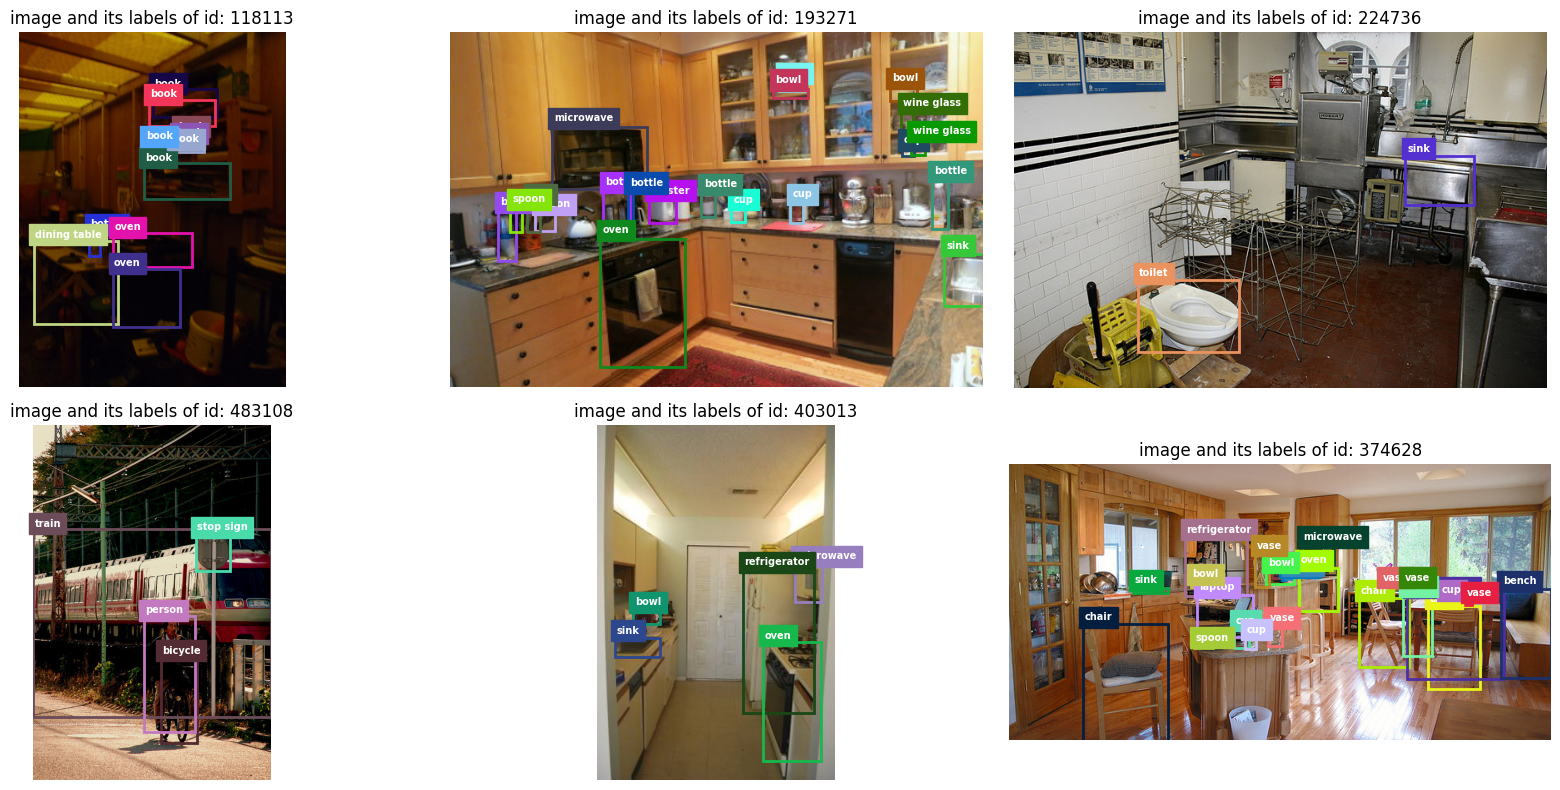

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(17, 8))
keys_temp = list(data_new.keys())[10:16]

for j in range(6):
    id = keys_temp[j]
    a = j // 3
    b = j % 3

    image_3d, image_2d = cv.open_image(base_path + training_image_path + data_new[id]["file_name"])
    ax[a, b].imshow(image_3d)
    ax[a, b].axis("off")
    ax[a, b].set_title(f"image and its labels of id: {id}")

    for i in range(len(data_new[id]["annotations"])):
        color = (random.random(),random.random(),random.random())
        bbox = data_new[id]["annotations"][i]["bbox"]
        ax[a, b].add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, edgecolor=(color),linewidth=2))
        ax[a, b].text(bbox[0] + 2, bbox[1] - 5, categories[data_new[id]["annotations"][i]["category_id"]], color='white', fontsize=7, weight='bold', backgroundcolor=color)

plt.tight_layout()
plt.show()

Frequency of each category in the dataset

frequency of each object:

person: 262465
car: 43867
chair: 38491
book: 24715
bottle: 24342
cup: 20650
dining table: 15714
bowl: 14358
traffic light: 12884
handbag: 12354
umbrella: 11431
bird: 10806
boat: 10759
truck: 9973
bench: 9838
sheep: 9509
banana: 9458
kite: 9076
motorcycle: 8725
backpack: 8720
potted plant: 8652
cow: 8147
wine glass: 7913
carrot: 7852
knife: 7770
broccoli: 7308
donut: 7179
bicycle: 7113
skis: 6646
vase: 6613
horse: 6587
tie: 6496
cell phone: 6434
orange: 6399
cake: 6353
sports ball: 6347
clock: 6334
suitcase: 6192
spoon: 6165
surfboard: 6126
bus: 6069
apple: 5851
pizza: 5821
tv: 5805
couch: 5779
remote: 5703
sink: 5610
skateboard: 5543
elephant: 5513
dog: 5508
fork: 5479
zebra: 5303
airplane: 5135
giraffe: 5131
laptop: 4970
tennis racket: 4812
teddy bear: 4793
cat: 4768
train: 4571
sandwich: 4373
bed: 4192
toilet: 4157
baseball glove: 3747
oven: 3334
baseball bat: 3276
hot dog: 2918
keyboard: 2855
snowboard: 2685
frisbee: 2682
refrigerator: 2637
mouse: 2262
sto

Text(0.5, 1.0, 'top 10 least common objects')

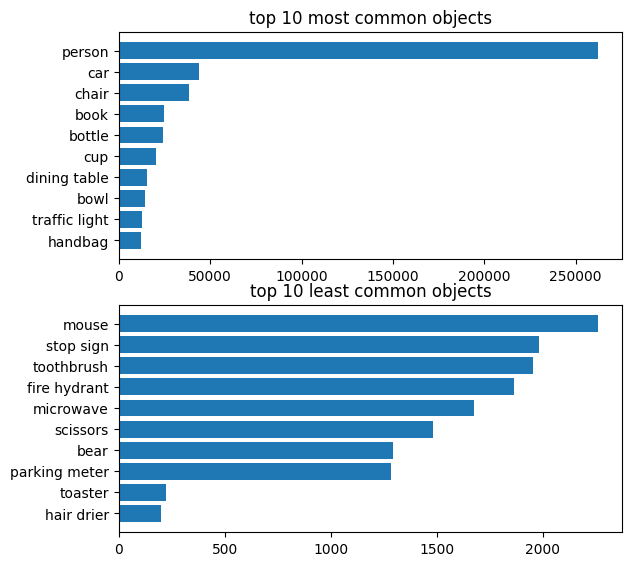

In [15]:
category_id_array = []
for id in image_id_array:
    for j in range(len(data_new[id]["annotations"])):
        category_id_array.append(data_new[id]["annotations"][j]["category_name"])

category_name_array, frequency_array = np.unique(category_id_array, return_counts=True)

sorted_indeces = np.argsort(frequency_array)
sorted_category_name_array = category_name_array[sorted_indeces]
sorted_frequency_array = frequency_array[sorted_indeces]

print("frequency of each object:\n")
for i in range(len(sorted_category_name_array) - 1, -1, -1):
    print(f"{sorted_category_name_array[i]}: {sorted_frequency_array[i]}")

plt.figure(figsize=(6.5, 6.5))

plt.subplot(2, 1, 1)
plt.barh(np.arange(len(sorted_frequency_array))[-10:], sorted_frequency_array[-10:])
plt.yticks(np.arange(len(sorted_frequency_array))[-10:], labels=sorted_category_name_array[-10:])
plt.title("top 10 most common objects")

plt.subplot(2, 1, 2)
plt.barh(np.arange(len(sorted_frequency_array))[:10], sorted_frequency_array[:10])
plt.yticks(np.arange(len(sorted_frequency_array))[:10], labels=sorted_category_name_array[:10])
plt.title("top 10 least common objects")


Image dimension

The code below collects the dimensions of every image and saves it as image_dimensions.npy. It is commented because it is very slow

In [16]:
# width_array = np.zeros(len(image_id_array))
# height_array = np.zeros(len(image_id_array))

# for i in range(len(image_id_array)):
#     print(i / number_of_images)
#     id = image_id_array[i]
#     image_3d = cv2.imread(base_path + training_image_path + data_new[id]["file_name"])
    
#     width = image_3d.shape[1]
#     height = image_3d.shape[0]

#     width_array[i] = width
#     height_array[i] = height

# image_dimensions_array = np.concatenate((np.array([width_array]), np.array([height_array])))
# np.save("image_dimensions.npy", image_dimensions_array)

Text(0.5, 1.0, 'scatterplot of image dimensions')

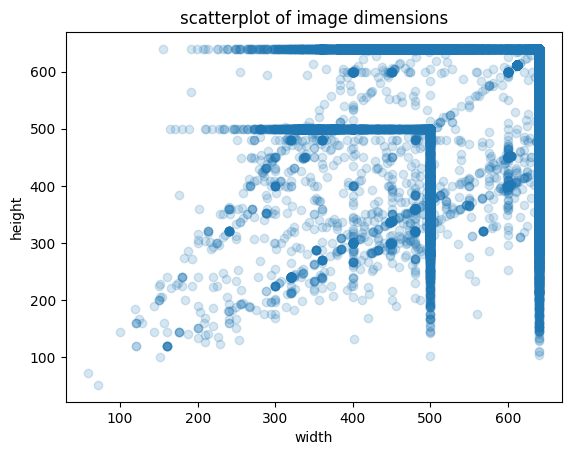

In [17]:
image_dimensions_array = np.load("image_dimensions.npy")
width_array = image_dimensions_array[0]
height_array = image_dimensions_array[1]

plt.scatter(width_array, height_array, alpha=0.18)
plt.xlabel("width")
plt.ylabel("height")
plt.title("scatterplot of image dimensions")

Outliers

largest width: 640.0
largest height: 640.0
smallest width: 59.0
smallest height: 51.0
largest aspect ratio: 6.153846153846154
smallest aspect ratio: 0.24375


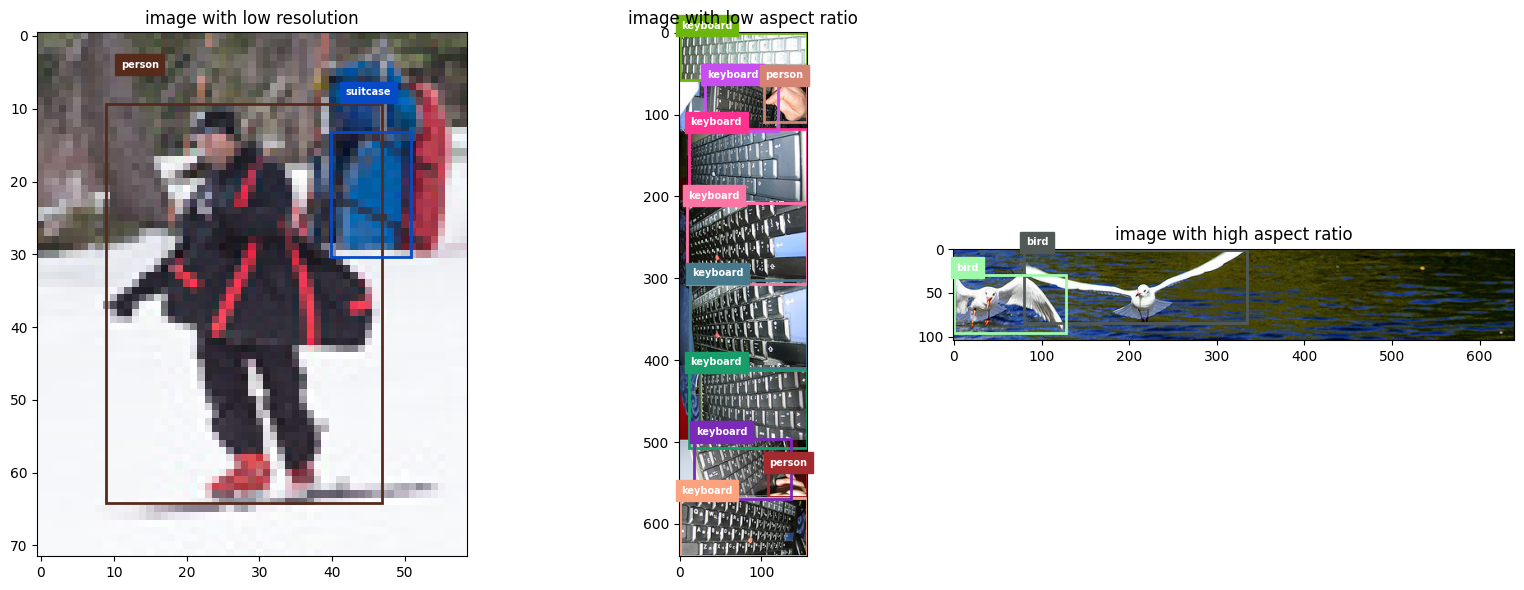

In [18]:
aspect_ratio_array = np.zeros(number_of_images)
for i in range(number_of_images):
    aspect_ratio_array[i] = width_array[i] / height_array[i]

temp_id_array = [image_id_array[np.argmin(width_array)], image_id_array[np.argmin(aspect_ratio_array)], image_id_array[np.argmax(aspect_ratio_array)]]
temp_labels = ["image with low resolution", "image with low aspect ratio", "image with high aspect ratio"]

fig, ax = plt.subplots(1, 3, figsize=(16, 6))
for j in range(3):
    id = temp_id_array[j]

    image_3d, image_2d = cv.open_image(base_path + training_image_path + data_new[id]["file_name"])
    ax[j].imshow(image_3d)
    ax[j].set_title(temp_labels[j])

    for i in range(len(data_new[id]["annotations"])):
        color = (random.random(),random.random(),random.random())
        bbox = data_new[id]["annotations"][i]["bbox"]
        ax[j].add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, edgecolor=(color),linewidth=2))
        ax[j].text(bbox[0] + 2, bbox[1] - 5, categories[data_new[id]["annotations"][i]["category_id"]], color='white', fontsize=7, weight='bold', backgroundcolor=color)

print(f"largest width: {np.max(width_array)}")
print(f"largest height: {np.max(height_array)}")
print(f"smallest width: {np.min(width_array)}")
print(f"smallest height: {np.min(height_array)}")
print(f"largest aspect ratio: {np.max(aspect_ratio_array)}")
print(f"smallest aspect ratio: {np.min(aspect_ratio_array)}")

plt.tight_layout()
plt.show()


# Pre-trained Model

The pre-trained Yolo we choose is YOLOv5s, and the training dataset used by yolov5s just happens to be the coco dataset, so we don't need to do transfer learning. We will also mention the relevant introduction in the report.

In [ ]:
model = torch.hub.load("ultralytics/yolov5","yolov5s")

In [ ]:
model.eval()

In [ ]:
def color_seed(rand_seed):
    random.seed(rand_seed)
    return {i:(random.random(),random.random(),random.random())  for i in categories.values()}

Visualize the image result, the result will show 3 images: Original Image, Original image annotated, Model Result

In [ ]:
def visualize_image_result(img_path,annotation):
    img = plt.imread(img_path)
    color = color_seed(40)
    
    fig,axes = plt.subplots(1,3,figsize=(20,6))
    
    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    axes[1].imshow(img)
    axes[1].set_title("Annotation Image")
    axes[1].axis('off')
    
    for i in annotation:
        x1, y1, x1_length, y1_length = i['bbox']
        label1 = i["category"]
        axes[1].add_patch(plt.Rectangle((x1, y1), x1_length, y1_length, fill=False, edgecolor=color[label1], linewidth=2))
        axes[1].text(x1, y1 - 10, f"{label1}", color='white', fontsize=11, weight='bold', backgroundcolor=color[label1])
        
    axes[2].imshow(img)
    axes[2].set_title("Result")
    axes[2].axis('off')
    
    
    result = model(img)
    df = result.pandas().xyxy[0]
    obj_num = df.shape[0]
    
    for j in range(obj_num):
        
        x = df.iloc[j]['xmin']
        y = df.iloc[j]['ymin']
        x_length = df.iloc[j]['xmax'] - df.iloc[j]['xmin']
        y_length = df.iloc[j]['ymax'] - df.iloc[j]['ymin']
        
        label = df.iloc[j]['name']
        confidence = df.iloc[j]['confidence']
        id2 = df.iloc[j]['class']
        axes[2].add_patch(plt.Rectangle((x, y), x_length, y_length, fill=False, edgecolor=color[label], linewidth=2))
        axes[2].text(x, y - 10, f"{label} {round(confidence, 2)}", color='white', fontsize=11, backgroundcolor=color[label])
    
    plt.tight_layout()
    plt.show()